In [1]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm
from collections import OrderedDict


def val(model, heatmap_loader, checkpoint_path, output_type='sigmoid'):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    GPU = 2
    new_state_dict = OrderedDict()
    for k, v in checkpoint['model_state_dict'].items():
        prefix = 'module.'
        name = k[len(prefix):]  # remove `module.` prefix
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.to(GPU)
    model.eval()

    test_results = []

    with torch.no_grad():
        for batch in tqdm(heatmap_loader):
            image_paths = batch['img_idx']
            phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
            left_text_ft = batch['left_text_emb']
            right_text_ft = batch['right_text_emb']
            left_heatmaps = batch['left_heatmap']
            right_heatmaps = batch['right_heatmap']
            labels = batch['label']
            
            left_heatmaps = left_heatmaps.unsqueeze(1).to(GPU)
            right_heatmaps = right_heatmaps.unsqueeze(1).to(GPU)
            left_text_ft = left_text_ft.squeeze(1).float().to(GPU)
            right_text_ft = right_text_ft.squeeze(1).float().to(GPU)
            label_tensor = labels.float().unsqueeze(1).to(GPU)
            
            outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
            # loss = criterion(outputs, label_tensor)
            if output_type == 'sigmoid':
                preds = (outputs > 0.5).float()
            elif output_type == 'softmax':
                _, preds = outputs.max(dim=1)
                preds = preds.unsqueeze(1)
            for i in range(len(image_paths)):
                test_results.append([image_paths[i], phrase_pairs[i], outputs[i].item(), preds[i].item(), labels[i].item()])      
    return test_results       

/work/adapting-CLIP-VGPs


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def visualize_val(test_results):
    # val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
    pred = [row[3] for row in test_results]
    gt = [row[4] for row in test_results]

    # Replace actual_labels and predicted_labels with your own data
    cm = confusion_matrix(gt, pred)

    # Define class labels
    class_labels = ['Negative', 'Positive']

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate precision
    precision = precision_score(gt, pred)

    # Calculate recall
    recall = recall_score(gt, pred)

    # Calculate F1 score
    f1 = f1_score(gt, pred)

    # Calculate accuracy
    acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

In [3]:
from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [4]:
from models.text_heatmap_gate import TextHeatmapGatedClassifier
model = TextHeatmapGatedClassifier(heatmap_only=True, use_dropout=True)
checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/14_checkpoint3.pt'

In [5]:
test_results = val(model, heatmap_loader,checkpoint_path)

  0%|          | 0/813 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 813/813 [05:58<00:00,  2.27it/s]


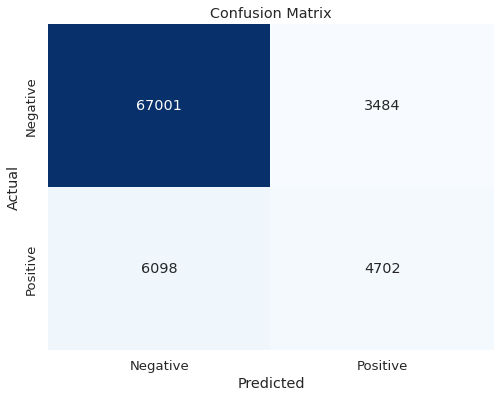

Accuracy: 0.8821184720428124
Precision: 0.5743953090642561
Recall: 0.43537037037037035
F1 Score: 0.49531233540503533


In [6]:
visualize_val(test_results)

In [28]:
model = TextHeatmapSigmoidClassifier(heatmap_only=False, gating=True, use_dropout=True)
checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/heatmap only/06_checkpoint5.pt'

In [29]:
test_results = val(model, heatmap_loader,checkpoint_path)

 74%|███████▍  | 600/813 [04:16<01:04,  3.30it/s]

In [ ]:
visualize_val(test_results)